# TE Academy Reputation Weighted Voting

## **Sybil-Resistance-1.0**

### Exploring the Sybil Resistance for a Specific Set of Parameters


In this notebook we examine three candidate mechanisms to explore their Sybil Resistance. 

## Process

For each mechanism, we will assign voter information based on a recent capture of voter NFT information, and an initial choice of NFT weights selected by TE Academy. 

We then do the following:
- Create an election where **all** current voters, vote for `candidate_A`.
- Keep introducing one new voter at a time, with minimum eligibility, who vote for `candidate_B`.
- See how many new voters it takes to flip the election to `candidate_B`. 



## Importing Code

We begin by importing necessary Python code. 

In [1]:
import pandas as pd
import sys
sys.path.append("..")

from copy import deepcopy
from math import ceil
from IPython.display import display, Markdown

from mechanisms.group_hug_mechanism import GroupHug
from mechanisms.rank_n_slide_mechanism import RankAndSlide
from mechanisms.single_choice_qcv_mechanism import SingleChoiceQuadraticCredibility

## Importing Voter Data

In the file `nft_data_may_28_2024_cleaned.csv` in the `data` folder, there is information pulled from the OtterSpace subgraph related to TE Academy NFT data. 

WWe can use this data to better understand the mechanisms. 

In [2]:
voter_data =  pd.read_csv("../data/nft_data_may_28_2024_cleaned.csv")
voter_data.head(5)

,Unnamed: 0,ID,NFTREP_V1,SPEAKER_ETHCC_PARIS23,STUDY_GROUP_HOST_C2_22_23,ETHCC_23,FUND_AUTHOR,STUDY_GROUP_HOST_360_22,STUDY_GROUP_HOST_FUND_22_23,SPEAKER_BARCAMP_PARIS_23,BARCAMP_PARIS_23,TEAM_BARCAMP_PARIS_23,FUND_MOD_1,FUND_MOD_2,FUND_MOD_3,FUND_MOD_4,FUND_MOD_5
0,0,0xbb8743ea733155fe5e81ed285aea72cc19b2ca87,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,1,0x049debbad61a20e21e872b06ef4f25be1253c802,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1
2,2,0xa481db1ac55683dfb2847c02e417b7e411bcbbea,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1
3,3,0x024bd3d1c3b6ba2277a744d7a99fbade9404a370,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1
4,4,0xa0b026b4b9e19ff2cbf5afbd9a679d93dedc2242,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1


The code below takes the nft_data_may_28_2024_cleaned.csv file and creates an illustration showing the number of NFTs held by all addresses connected to the Token Engineering Academy.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Load the CSV file
file_path = '../data/nft_data_may_28_2024_cleaned.csv'
df = pd.read_csv(file_path)

# Count the number of NFTs for each address as series
nft_counts = (df.drop(columns=['Unnamed: 0', 'ID'])).sum(axis=1)


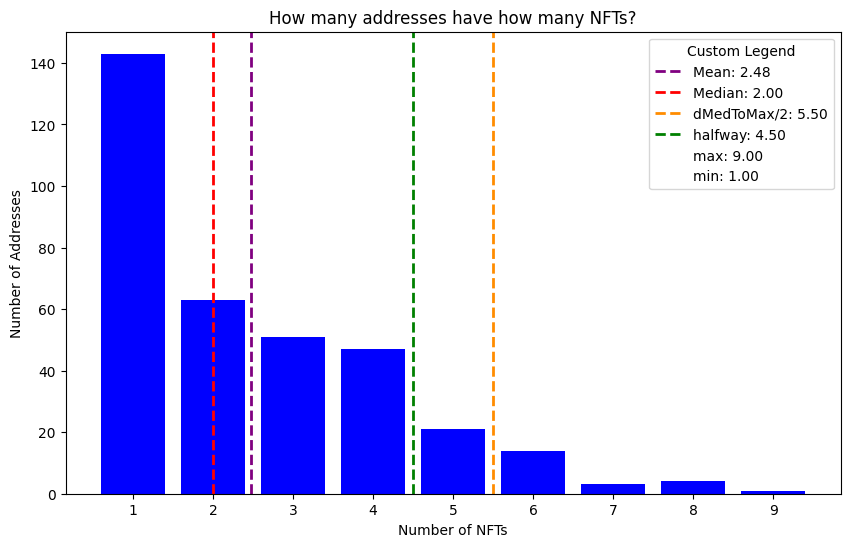

In [4]:

# Calculate the mean, median, and maximum
mean_value = nft_counts.mean()
median_value = nft_counts.median()
max_value = nft_counts.max()
min_value = nft_counts.min()
# Calculate the halfway value between median and maximum
dMedToMaxHalf = median_value + ((max_value - median_value) / 2)
# Calculate the halfway line from max_value
halfWayLine = max_value/2

# Counts how many addresses hold how many NFTs (group by number-of-NFT-held) and sorts ascending
counts = nft_counts.value_counts().sort_index()

# Ensure all values from 1 to max_value are included to maintain a flexible but consistent x-axis
for i in range(1, (max_value+1)):
    if i not in counts:
        counts[i] = 0

# Sort the counts again after ensuring all values from 1 to 9 are included
counts = counts.sort_index()

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(counts.index, counts.values, color='blue')

# Adding vertical lines for mean, median, and halfway point
plt.axvline(x=mean_value, color='purple', linestyle='--', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(x=median_value, color='red', linestyle='--', linewidth=2, label=f'Median: {median_value:.2f}')
plt.axvline(x=dMedToMaxHalf, color='darkorange', linestyle='--', linewidth=2, label=f'dMedToMax/2: {dMedToMaxHalf:.2f}')
plt.axvline(x=halfWayLine, color='green', linestyle='--', linewidth=2, label=f'halfway: {halfWayLine:.2f}')

# Set the x-axis ticks to range from 1 to max_value
plt.xticks(range(1, (max_value+1)))

# Adding a custom legend with specific text values
# Custom labels for the legend
custom_legend_labels = []

# Create proxy artists for the custom legend with no color
custom_legend_handles = [Line2D([0], [0], color='none', label=label) for label in custom_legend_labels]

# Add the mean, median, and deltaMedianToMax-line to the legend handles
custom_legend_handles.extend([
    Line2D([0], [0], color='purple', linestyle='--', linewidth=2, label=f'Mean: {mean_value:.2f}'),
    Line2D([0], [0], color='red', linestyle='--', linewidth=2, label=f'Median: {median_value:.2f}'),
    Line2D([0], [0], color='darkorange', linestyle='--', linewidth=2, label=f'dMedToMax/2: {dMedToMaxHalf:.2f}'),
    Line2D([0], [0], color='green', linestyle='--', linewidth=2, label=f'halfway: {halfWayLine:.2f}'),
    Line2D([0], [0], color='none', linestyle='', linewidth=0, label=f'max: {max_value:.2f}'),
    Line2D([0], [0], color='none', linestyle='', linewidth=0, label=f'min: {min_value:.2f}')
])

# Add the legend to the plot
plt.legend(handles=custom_legend_handles, title='Custom Legend')

# Add labels and title
plt.xlabel('Number of NFTs')
plt.ylabel('Number of Addresses')
plt.title('How many addresses have how many NFTs?')

# Display the plot
plt.show()

We do a bit of preprocessing to convert the voter information to a dictionary format that we need. 

In the final nested dictionary:
* the keys are strings corresponding to wallet IDs
* the values are dictionaries, which give the NFT information for each wallet

In [5]:
# We may need to drop a specific column. 
voter_data.drop(columns = ['Unnamed: 0'], 
                inplace = True)
voter_data.set_index('ID', inplace = True)

In [6]:
voter_dict = voter_data.to_dict(orient='index')

In [7]:
voter_dict

{'0xbb8743ea733155fe5e81ed285aea72cc19b2ca87': {'NFTREP_V1': 0,
  'SPEAKER_ETHCC_PARIS23': 0,
  'STUDY_GROUP_HOST_C2_22_23': 0,
  'ETHCC_23': 0,
  'FUND_AUTHOR': 0,
  'STUDY_GROUP_HOST_360_22': 0,
  'STUDY_GROUP_HOST_FUND_22_23': 0,
  'SPEAKER_BARCAMP_PARIS_23': 0,
  'BARCAMP_PARIS_23': 0,
  'TEAM_BARCAMP_PARIS_23': 0,
  'FUND_MOD_1': 0,
  'FUND_MOD_2': 0,
  'FUND_MOD_3': 1,
  'FUND_MOD_4': 1,
  'FUND_MOD_5': 0},
 '0x049debbad61a20e21e872b06ef4f25be1253c802': {'NFTREP_V1': 0,
  'SPEAKER_ETHCC_PARIS23': 0,
  'STUDY_GROUP_HOST_C2_22_23': 0,
  'ETHCC_23': 1,
  'FUND_AUTHOR': 0,
  'STUDY_GROUP_HOST_360_22': 0,
  'STUDY_GROUP_HOST_FUND_22_23': 0,
  'SPEAKER_BARCAMP_PARIS_23': 0,
  'BARCAMP_PARIS_23': 0,
  'TEAM_BARCAMP_PARIS_23': 0,
  'FUND_MOD_1': 0,
  'FUND_MOD_2': 0,
  'FUND_MOD_3': 1,
  'FUND_MOD_4': 1,
  'FUND_MOD_5': 1},
 '0xa481db1ac55683dfb2847c02e417b7e411bcbbea': {'NFTREP_V1': 1,
  'SPEAKER_ETHCC_PARIS23': 0,
  'STUDY_GROUP_HOST_C2_22_23': 0,
  'ETHCC_23': 0,
  'FUND_AUTHOR': 0,
 

Any time we need to refer to voter NFT information, we can use this `voter_dict` variable. Below is an example of *one* voter. 

## Reading NFT Weights

We use the voting weights suggested as potential initial choices from TE Academy, which are stored in the `default_voting_weights.csv` file in the `data` directory. 

In [8]:
nft_weights = pd.read_csv("../data/default_voting_weights.csv")

We see a small sample here. 

In [9]:
nft_weights.head(5)

,Name,CodeName,Category,Count,Weight
0,TE FUNDAMENTALS COURSE AUTHOR LAUNCH 2022,FUND_AUTHOR,POE,4.0,20.0
1,Token Engineering @EthCC Paris 2023 - Speaker,SPEAKER_ETHCC_PARIS23,POE,7.0,16.0
2,TE FUNDAMENTALS 1,FUND_MOD_1,POK,332.0,7.0
3,TE FUNDAMENTALS 2,FUND_MOD_2,POK,249.0,7.0
4,TE FUNDAMENTALS 3,FUND_MOD_3,POK,168.0,7.0


We need to do a small bit of processing to get this information into a dictionary.

In [10]:
# Convert csv file to dictionary
nft_weights_dict = {
    nft_weights.at[k,"CodeName"]: nft_weights.at[k,"Weight"]
    for k in range(len(nft_weights))
}

In [11]:
nft_weights_dict

{'FUND_AUTHOR': 20.0,
 'SPEAKER_ETHCC_PARIS23': 16.0,
 'FUND_MOD_1': 7.0,
 'FUND_MOD_2': 7.0,
 'FUND_MOD_3': 7.0,
 'FUND_MOD_4': 7.0,
 'FUND_MOD_5': 7.0,
 'NFTREP_V1': 3.0,
 'ETHCC_23': 1.0,
 'SPEAKER_BARCAMP_PARIS_23': 12.0,
 'BARCAMP_PARIS_23': 5.0,
 'TEAM_BARCAMP_PARIS_23': 1.0,
 'STUDY_GROUP_HOST_FUND_22_23': 10.0,
 'STUDY_GROUP_HOST_C2_22_23': 10.0,
 'STUDY_GROUP_HOST_360_22': 10.0,
 'STUDY_SEASON_REGISTRATION': 1.0,
 'LIVE_TRACK_1': 10.0,
 'LIVE_TRACK_3': 10.0,
 'LIVE_TRACK_4': 10.0,
 'LIVE_TRACK_5': 10.0,
 'LIVE_TRACK_6': 10.0,
 'LIVE_TRACK_7': 10.0,
 'LIVE_TRACK_8': 10.0,
 'FELLOWSHIP_COMM': 16.0,
 'STUDY_SEASON_SPEAKER': 16.0,
 'FUND_WE_MADE_IT': 10.0,
 'FUND_MOD_3_AND_4': 5.0,
 'FUND_ALL': 10.0}

In [12]:
all_nft_names = list(nft_weights_dict.keys())

In [13]:
all_nft_names

['FUND_AUTHOR',
 'SPEAKER_ETHCC_PARIS23',
 'FUND_MOD_1',
 'FUND_MOD_2',
 'FUND_MOD_3',
 'FUND_MOD_4',
 'FUND_MOD_5',
 'NFTREP_V1',
 'ETHCC_23',
 'SPEAKER_BARCAMP_PARIS_23',
 'BARCAMP_PARIS_23',
 'TEAM_BARCAMP_PARIS_23',
 'STUDY_GROUP_HOST_FUND_22_23',
 'STUDY_GROUP_HOST_C2_22_23',
 'STUDY_GROUP_HOST_360_22',
 'STUDY_SEASON_REGISTRATION',
 'LIVE_TRACK_1',
 'LIVE_TRACK_3',
 'LIVE_TRACK_4',
 'LIVE_TRACK_5',
 'LIVE_TRACK_6',
 'LIVE_TRACK_7',
 'LIVE_TRACK_8',
 'FELLOWSHIP_COMM',
 'STUDY_SEASON_SPEAKER',
 'FUND_WE_MADE_IT',
 'FUND_MOD_3_AND_4',
 'FUND_ALL']

## Sorting The Voters By Weight

For our purposes, it will be important to have the voters sorted by how much "raw" voting power they have based on their NFTs. Strictly speaking, this is not necessary for the decisions we need here, but it can be useful for other ones. 

In [14]:
for voter in voter_dict.keys():
    voter_dict[voter]['total_weight'] = 0
    for nft in voter_dict.get(voter).keys():
        voter_dict[voter]['total_weight'] += voter_dict.get(voter).get(nft) * nft_weights_dict.get(nft, 0)

sorted_voter_dict = {k: voter_dict[k] 
                     for k 
                     in sorted(voter_dict, 
                               key=lambda x: voter_dict[x]['total_weight'],
                               reverse=True)}

In [15]:
sorted_voter_dict

{'0xfcbc07905fee2d64025461b8ddb27f77f256827f': {'NFTREP_V1': 0,
  'SPEAKER_ETHCC_PARIS23': 1,
  'STUDY_GROUP_HOST_C2_22_23': 0,
  'ETHCC_23': 0,
  'FUND_AUTHOR': 1,
  'STUDY_GROUP_HOST_360_22': 0,
  'STUDY_GROUP_HOST_FUND_22_23': 0,
  'SPEAKER_BARCAMP_PARIS_23': 1,
  'BARCAMP_PARIS_23': 0,
  'TEAM_BARCAMP_PARIS_23': 1,
  'FUND_MOD_1': 1,
  'FUND_MOD_2': 1,
  'FUND_MOD_3': 1,
  'FUND_MOD_4': 1,
  'FUND_MOD_5': 0,
  'total_weight': 77.0},
 '0x3e0cf03f718520f30300266dcf4db50ba12d3331': {'NFTREP_V1': 0,
  'SPEAKER_ETHCC_PARIS23': 0,
  'STUDY_GROUP_HOST_C2_22_23': 0,
  'ETHCC_23': 0,
  'FUND_AUTHOR': 0,
  'STUDY_GROUP_HOST_360_22': 0,
  'STUDY_GROUP_HOST_FUND_22_23': 1,
  'SPEAKER_BARCAMP_PARIS_23': 1,
  'BARCAMP_PARIS_23': 0,
  'TEAM_BARCAMP_PARIS_23': 1,
  'FUND_MOD_1': 1,
  'FUND_MOD_2': 1,
  'FUND_MOD_3': 1,
  'FUND_MOD_4': 1,
  'FUND_MOD_5': 1,
  'total_weight': 58.0},
 '0x5658f4b362e95c0bc32d5ce0051457882db92ee5': {'NFTREP_V1': 1,
  'SPEAKER_ETHCC_PARIS23': 0,
  'STUDY_GROUP_HOST_C2_2

Since we are doing copy-paste/template work, many of the variable names below are hard-coded. To simplify things later on, we will re-use the `voter_dict` variable name to store a copy of `sorted_voter_dict`.

In [16]:
voter_dict = deepcopy(sorted_voter_dict)

In [17]:
voter_dict

{'0xfcbc07905fee2d64025461b8ddb27f77f256827f': {'NFTREP_V1': 0,
  'SPEAKER_ETHCC_PARIS23': 1,
  'STUDY_GROUP_HOST_C2_22_23': 0,
  'ETHCC_23': 0,
  'FUND_AUTHOR': 1,
  'STUDY_GROUP_HOST_360_22': 0,
  'STUDY_GROUP_HOST_FUND_22_23': 0,
  'SPEAKER_BARCAMP_PARIS_23': 1,
  'BARCAMP_PARIS_23': 0,
  'TEAM_BARCAMP_PARIS_23': 1,
  'FUND_MOD_1': 1,
  'FUND_MOD_2': 1,
  'FUND_MOD_3': 1,
  'FUND_MOD_4': 1,
  'FUND_MOD_5': 0,
  'total_weight': 77.0},
 '0x3e0cf03f718520f30300266dcf4db50ba12d3331': {'NFTREP_V1': 0,
  'SPEAKER_ETHCC_PARIS23': 0,
  'STUDY_GROUP_HOST_C2_22_23': 0,
  'ETHCC_23': 0,
  'FUND_AUTHOR': 0,
  'STUDY_GROUP_HOST_360_22': 0,
  'STUDY_GROUP_HOST_FUND_22_23': 1,
  'SPEAKER_BARCAMP_PARIS_23': 1,
  'BARCAMP_PARIS_23': 0,
  'TEAM_BARCAMP_PARIS_23': 1,
  'FUND_MOD_1': 1,
  'FUND_MOD_2': 1,
  'FUND_MOD_3': 1,
  'FUND_MOD_4': 1,
  'FUND_MOD_5': 1,
  'total_weight': 58.0},
 '0x5658f4b362e95c0bc32d5ce0051457882db92ee5': {'NFTREP_V1': 1,
  'SPEAKER_ETHCC_PARIS23': 0,
  'STUDY_GROUP_HOST_C2_2

## Checking Swifties Number for Quadratic Credibility Voting

We define an instance of the Single Choice Quadratic Credibility mechanism.

In [18]:
scqc_mechanism = SingleChoiceQuadraticCredibility()

We give the voters their points according to those NFT weights, distributed as the SingleChoiceQuadraticCredibility mechanism will. 

In [19]:
scqc_voters_points = scqc_mechanism.allocate_points_from_credentials(
    voter_credentials = voter_dict,
    credential_weights = nft_weights_dict,
    total_amount_to_allocate = 10_000
)

In [20]:
scqc_voters_points

{'0xfcbc07905fee2d64025461b8ddb27f77f256827f': {'points': 134.3804537521815},
 '0x3e0cf03f718520f30300266dcf4db50ba12d3331': {'points': 101.22164048865619},
 '0x5658f4b362e95c0bc32d5ce0051457882db92ee5': {'points': 97.73123909249564},
 '0xcc449df434d886576202eef7c9ef2aa0948c310b': {'points': 83.76963350785341},
 '0x0e950e75b652878e6a3d3ecb6e5797452a918a05': {'points': 82.02443280977313},
 '0x148d424f74c323d3950a8562760aa76e4c58615b': {'points': 80.27923211169285},
 '0xf9278a270d2100ea5e76e8d85ac712b2cb7ec685': {'points': 78.53403141361257},
 '0x47f793e8af738f4b61d7e2d207c6d29c713d1a84': {'points': 76.78883071553228},
 '0x6d465d2081b799770d0ce7e755d8db1665903ffb': {'points': 68.06282722513089},
 '0x024bd3d1c3b6ba2277a744d7a99fbade9404a370': {'points': 66.3176265270506},
 '0xa0b026b4b9e19ff2cbf5afbd9a679d93dedc2242': {'points': 66.3176265270506},
 '0x222cf246a3d56d61030ca49f5e6ffd6c20c3dc4f': {'points': 66.3176265270506},
 '0xc8eba9130f40a0ea9be530407e5b4f7199118864': {'points': 66.31762

We create a reference dictionary of vote information, where all candidates vote for candidate_A.

In [21]:
all_votes_for_A = {voter: {"candidate_A": scqc_voters_points.get(voter).get("points")}
                           for voter in scqc_voters_points.keys() }

This is what this initial dictionary looks like. 

In [22]:
all_votes_for_A

{'0xfcbc07905fee2d64025461b8ddb27f77f256827f': {'candidate_A': 134.3804537521815},
 '0x3e0cf03f718520f30300266dcf4db50ba12d3331': {'candidate_A': 101.22164048865619},
 '0x5658f4b362e95c0bc32d5ce0051457882db92ee5': {'candidate_A': 97.73123909249564},
 '0xcc449df434d886576202eef7c9ef2aa0948c310b': {'candidate_A': 83.76963350785341},
 '0x0e950e75b652878e6a3d3ecb6e5797452a918a05': {'candidate_A': 82.02443280977313},
 '0x148d424f74c323d3950a8562760aa76e4c58615b': {'candidate_A': 80.27923211169285},
 '0xf9278a270d2100ea5e76e8d85ac712b2cb7ec685': {'candidate_A': 78.53403141361257},
 '0x47f793e8af738f4b61d7e2d207c6d29c713d1a84': {'candidate_A': 76.78883071553228},
 '0x6d465d2081b799770d0ce7e755d8db1665903ffb': {'candidate_A': 68.06282722513089},
 '0x024bd3d1c3b6ba2277a744d7a99fbade9404a370': {'candidate_A': 66.3176265270506},
 '0xa0b026b4b9e19ff2cbf5afbd9a679d93dedc2242': {'candidate_A': 66.3176265270506},
 '0x222cf246a3d56d61030ca49f5e6ffd6c20c3dc4f': {'candidate_A': 66.3176265270506},
 '0xc8

In [23]:
#NOTE: This function could be refactored to take in the NFT weights at the outset
# for easier experimentation. 
 
def find_swifty_number_scqc(quad_mechanism,
                            initial_voter_dict,
                           nft_weights_dict_to_use):
    """
    This method should find the "Swifty Number" of new low-power voters
    who can change the election result.

    Step 1: We create data with the current voters, all voting for candidate_A.
    Step 2: We find the lowest NFT value that could be added. 
    Step 3: We keep adding voters, who only hold the lowest-value NFT and are voting for candidate_B.
    Step 4: We see how many such voters would need to be added.
    """
     
    ######################################
    # Step 1: Setup                     ##
    ######################################

    # Clone initial voter dictionary
    this_election_voters = deepcopy(initial_voter_dict)

    
    ######################################
    # Step 2: Find a lowest-weight NFT  ##
    ######################################

    # Find the key with the lowest value in the nft_weights_dict_to_use
    # If there are many, we arbitrarily select one. 
    lowest_nft_key = min(nft_weights_dict_to_use, 
                         key=nft_weights_dict_to_use.get)
    lowest_nft_value = nft_weights_dict_to_use[lowest_nft_key]
    
    # Create a re-usable dictionary that is pre-filled with
    # 1 for the lowest-valued NFT, and 0 for all others. 
    only_lowest_nft_dict = {
         nft: 0 for nft in nft_weights_dict_to_use.keys()
    }

    only_lowest_nft_dict[lowest_nft_key] = 1.0


    ######################################
    # Step 3: Set up election state     ##
    ######################################
    election_result_has_changed = False
    
    voter_nft_info = {}

    ######################################
    # Step 4: Run election              ##
    ######################################
    
    # Keep track how many candidate_B voters there are
    num_new_B_votes = 0

    while not(election_result_has_changed):

        # Keep track of who the new voter is
        num_new_B_votes += 1
        new_voter_ID_number = num_new_B_votes
        new_voter_name = f"swifty_{new_voter_ID_number}"

        # Add their "cheapest NFT only" information
        this_election_voters[new_voter_name] = deepcopy(only_lowest_nft_dict)

        # Create the necessary points data
        this_election_voters_points =  scqc_mechanism.allocate_points_from_credentials(
                                            voter_credentials = this_election_voters,
                                            credential_weights = nft_weights_dict_to_use,
                                        )
        # Separate the two groups
        real_voters = [name 
                       for name 
                       in this_election_voters_points.keys()
                       if not ("swifty" in name)]
        swifties =     [name 
                       for name 
                       in this_election_voters_points.keys()
                       if ("swifty" in name)]
        
        # Create the votes for the two groups
        real_voters_data = {real_voter: 
                                {
                                    "candidate_A" : this_election_voters_points.get(real_voter).get("points")
                                } 
                                for real_voter 
                                in real_voters            
                            }
        
        swifties_data = {swifty_voter: 
                                {
                                    "candidate_B" : this_election_voters_points.get(swifty_voter).get("points") 
                                } 
                                for swifty_voter
                                in swifties            
                        }

        # Combine the two voter subgroups into one voter population
        combined_voters_dict = {**real_voters_data, **swifties_data}

        # Create vote results
        winner, results = quad_mechanism.calculate(voters = this_election_voters_points,
                                              voter_choices = combined_voters_dict)
        
        # Check if this configuration leads to a new winner. 
        election_result_has_changed = (winner == "candidate_B")
        # AT some point this breaks the loop.

    return num_new_B_votes, results, combined_voters_dict


In [24]:
scqc_mechanism = SingleChoiceQuadraticCredibility()

In [25]:
scqc_swifty_number, scqc_results, final_dict = find_swifty_number_scqc(quad_mechanism = scqc_mechanism,
                        initial_voter_dict = voter_dict,
                        nft_weights_dict_to_use = nft_weights_dict)

In [26]:
print(f"The swifty number for Quadratic Credibility is {scqc_swifty_number}.")

The swifty number for Quadratic Credibility is 1305.


In [27]:
len(voter_dict)

347

## Checking Swifty Number for Rank-and-Slide

In [28]:
rs_mechanism = RankAndSlide()

In [29]:
rank_and_slide_voters_points = rs_mechanism.allocate_points_from_credentials(
    voter_credentials=voter_dict,
    credential_weights=nft_weights_dict
)

In [30]:
#NOTE: This function could be refactored to take in the NFT weights at the outset
# for easier experimentation. 
 
def find_swifty_number_rs(rank_and_slide_mechanism,
                          initial_voter_dict,
                          nft_weights_dict_to_use):
    """
    This method should find the "Swifty Number" of new low-power voters
    who can change the election result using the Rank-and-Slide mechanism.

    Step 1: We create data with the current voters, all voting for candidate_A.
    Step 2: We find the lowest NFT value that could be added. 
    Step 3: We keep adding voters, who only hold the lowest-value NFT and are voting for candidate_B.
    Step 4: We see how many such voters would need to be added.
    """
     
    ######################################
    # Step 1: Setup                     ##
    ######################################

    # Clone initial voter dictionary
    this_election_voters = deepcopy(initial_voter_dict)
    print(this_election_voters)

    
    ######################################
    # Step 2: Find a lowest-weight NFT  ##
    ######################################

    # Find the key with the lowest value in the nft_weights_dict_to_use
    # If there are many, we arbitrarily select one. 
    lowest_nft_key = min(nft_weights_dict_to_use, 
                         key=nft_weights_dict_to_use.get)
    lowest_nft_value = nft_weights_dict_to_use[lowest_nft_key]
    
    # Create a re-usable dictionary that is pre-filled with
    # 1 for the lowest-valued NFT, and 0 for all others. 
    only_lowest_nft_dict = {
         nft: 0 for nft in nft_weights_dict_to_use.keys()
    }

    only_lowest_nft_dict[lowest_nft_key] = 1.0


    ######################################
    # Step 3: Set up election state     ##
    ######################################
    election_result_has_changed = False
    
    voter_nft_info = {}

    ######################################
    # Step 4: Run election              ##
    ######################################
    
    # Keep track how many candidate_B voters there are
    num_new_B_votes = 0

    while not(election_result_has_changed):

        # Keep track of who the new voter is
        num_new_B_votes += 1
        new_voter_ID_number = num_new_B_votes
        new_voter_name = f"swifty_{new_voter_ID_number}"

        # Add their "cheapest NFT only" information
        this_election_voters[new_voter_name] = deepcopy(only_lowest_nft_dict)

        # Create the necessary points data
        this_election_voters_points =  rank_and_slide_mechanism.allocate_points_from_credentials(
                                            voter_credentials = this_election_voters,
                                            credential_weights = nft_weights_dict_to_use,
                                        )
        # Separate the two groups
        real_voters = [name 
                       for name 
                       in this_election_voters_points.keys()
                       if not ("swifty" in name)]
        swifties =     [name 
                       for name 
                       in this_election_voters_points.keys()
                       if ("swifty" in name)]
        
        # Create the votes for the two groups
        real_voters_data = {real_voter: 
                                {
                                    "candidate_A" : this_election_voters_points.get(real_voter).get("points")
                                } 
                                for real_voter 
                                in real_voters            
                            }
        
        swifties_data = {swifty_voter: 
                                {
                                    "candidate_B" : this_election_voters_points.get(swifty_voter).get("points") 
                                } 
                                for swifty_voter
                                in swifties            
                        }

        # Combine the two voter subgroups into one voter population
        combined_voters_dict = {**real_voters_data, **swifties_data}

        # Create vote results
        winner, results = rank_and_slide_mechanism.calculate(voters = this_election_voters_points,
                                              voter_choices = combined_voters_dict)
        
        # Check if this configuration leads to a new winner. 
        election_result_has_changed = (winner == "candidate_B")
        # At some point this breaks the loop.

    return num_new_B_votes, results, combined_voters_dict


In [31]:
rs_swifty_number, rs_results, final_dict = find_swifty_number_rs(rank_and_slide_mechanism = rs_mechanism,
                        initial_voter_dict = voter_dict,
                        nft_weights_dict_to_use = nft_weights_dict)

{'0xfcbc07905fee2d64025461b8ddb27f77f256827f': {'NFTREP_V1': 0, 'SPEAKER_ETHCC_PARIS23': 1, 'STUDY_GROUP_HOST_C2_22_23': 0, 'ETHCC_23': 0, 'FUND_AUTHOR': 1, 'STUDY_GROUP_HOST_360_22': 0, 'STUDY_GROUP_HOST_FUND_22_23': 0, 'SPEAKER_BARCAMP_PARIS_23': 1, 'BARCAMP_PARIS_23': 0, 'TEAM_BARCAMP_PARIS_23': 1, 'FUND_MOD_1': 1, 'FUND_MOD_2': 1, 'FUND_MOD_3': 1, 'FUND_MOD_4': 1, 'FUND_MOD_5': 0, 'total_weight': 77.0}, '0x3e0cf03f718520f30300266dcf4db50ba12d3331': {'NFTREP_V1': 0, 'SPEAKER_ETHCC_PARIS23': 0, 'STUDY_GROUP_HOST_C2_22_23': 0, 'ETHCC_23': 0, 'FUND_AUTHOR': 0, 'STUDY_GROUP_HOST_360_22': 0, 'STUDY_GROUP_HOST_FUND_22_23': 1, 'SPEAKER_BARCAMP_PARIS_23': 1, 'BARCAMP_PARIS_23': 0, 'TEAM_BARCAMP_PARIS_23': 1, 'FUND_MOD_1': 1, 'FUND_MOD_2': 1, 'FUND_MOD_3': 1, 'FUND_MOD_4': 1, 'FUND_MOD_5': 1, 'total_weight': 58.0}, '0x5658f4b362e95c0bc32d5ce0051457882db92ee5': {'NFTREP_V1': 1, 'SPEAKER_ETHCC_PARIS23': 0, 'STUDY_GROUP_HOST_C2_22_23': 0, 'ETHCC_23': 1, 'FUND_AUTHOR': 0, 'STUDY_GROUP_HOST_360_2

In [32]:
print(f"The Swifty Number of Rank-and-Slide is {rs_swifty_number}.")

The Swifty Number of Rank-and-Slide is 5731.


In Rank and Slide with the current settings, the Swifty Number is 84. 

## Swifty Number in GroupHug

In [34]:
gh_mechanism = GroupHug(nft_weights=nft_weights_dict)

In [35]:
def find_nakamoto_in_group_hug(group_hug_mechanism,
                                voter_info_dict):

    # Track how many people have voted for B
    num_voters_for_B = 0
    
    # Create reference dictionary with all votes for A
    all_votes_for_A = {voter: "candidate_A"
                           for voter in voter_info_dict.keys() }
    # Create an identical dictionary 
    B_gaining_votes = {voter: "candidate_A" 
                           for voter in voter_info_dict.keys() }

    for voter in voter_info_dict.keys():
        # Take the default "everyone votes for A" election
        # and change one vote to B
        B_gaining_votes[voter] = "candidate_B"
        
        # Increase the count of how many voters voted for B
        num_voters_for_B = num_voters_for_B + 1
                    
        winner, results = group_hug_mechanism.calculate(voters = voter_info_dict,
                                              voter_choices = B_gaining_votes)
        if winner == "candidate_B":
            return num_voters_for_B, results


    return num_voters_for_B, results

In [36]:
gh_nakamoto_coefficient, final_votes = find_nakamoto_in_group_hug(group_hug_mechanism = gh_mechanism,
                            voter_info_dict = voter_dict)


Experts: {'candidate_A': 94.4, 'candidate_B': 5.6}
Intellectuals: {'candidate_A': 99.4, 'candidate_B': 0.6}
Participants: {'candidate_A': 100.0, 'candidate_B': 0.0}
Community: {'candidate_A': 99.7, 'candidate_B': 0.3}

Experts: {'candidate_A': 88.9, 'candidate_B': 11.1}
Intellectuals: {'candidate_A': 98.7, 'candidate_B': 1.3}
Participants: {'candidate_A': 96.0, 'candidate_B': 4.0}
Community: {'candidate_A': 99.4, 'candidate_B': 0.6}

Experts: {'candidate_A': 83.3, 'candidate_B': 16.7}
Intellectuals: {'candidate_A': 98.0, 'candidate_B': 2.0}
Participants: {'candidate_A': 95.7, 'candidate_B': 4.3}
Community: {'candidate_A': 99.1, 'candidate_B': 0.9}

Experts: {'candidate_A': 77.8, 'candidate_B': 22.2}
Intellectuals: {'candidate_A': 98.0, 'candidate_B': 2.0}
Participants: {'candidate_A': 95.7, 'candidate_B': 4.3}
Community: {'candidate_A': 98.8, 'candidate_B': 1.2}

Experts: {'candidate_A': 77.8, 'candidate_B': 22.2}
Intellectuals: {'candidate_A': 97.3, 'candidate_B': 2.7}
Participants: 

In [ ]:
print(f"In GroupHug with the current settings, the Nakamoto Coefficient is {gh_nakamoto_coefficient}. \n This means {100 * gh_nakamoto_coefficient/len(voter_dict)} % of the voters would be enough to win.")

In [ ]:
final_votes